In [1]:
#### Librerías segunda sesión
import os 
import pandas as pd
import numpy as np 
import pyreadr as pr
import plotly.express as px
import matplotlib as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12

In [2]:
#### Fijamos el directorio de trabajo
os.chdir("/home/fabian/Documentos")

In [3]:
#### Tamaño de las gráficas
plt.rcParams["figure.figsize"] = [16, 8]

In [4]:
#### Importo el dataframe en formato RData
base = pr.read_r("desempleo_col.RData")

In [5]:
#### Estudiando la colección
print(base.keys())

odict_keys(['base_1'])


In [6]:
#### Extraigo el dataframe de la colección
bs = base["base_1"]

In [7]:
#### Estudio el df
bs.head()

fecha  ocupacion  desempleo
0  2021-04  51.774138  17.371046
1  2021-03  53.411269  16.797761
2  2021-02  53.194328  18.085593
3  2021-01  51.062154  19.457349
4  2020-12  53.812622  15.585572

In [8]:
#### Tipo de bs
type(bs)

pandas.core.frame.DataFrame

In [9]:
#### Tipo de las columnas
bs.dtypes

fecha         object
ocupacion    float64
desempleo    float64
dtype: object

In [10]:
#### Convirtiendo la primera columna a fecha
bs["fecha"] = pd.to_datetime(bs.fecha, format = "%Y-%m-%d")

In [11]:
bs.head()

fecha  ocupacion  desempleo
0 2021-04-01  51.774138  17.371046
1 2021-03-01  53.411269  16.797761
2 2021-02-01  53.194328  18.085593
3 2021-01-01  51.062154  19.457349
4 2020-12-01  53.812622  15.585572

In [12]:
#### Ordeno el df con las fechas
bs = bs.sort_values("fecha", ignore_index = True)

In [13]:
#### Elimino la columa "ocupacion"
del bs["ocupacion"]

In [14]:
#### Convierto fecha a index
bs = bs.set_index("fecha")

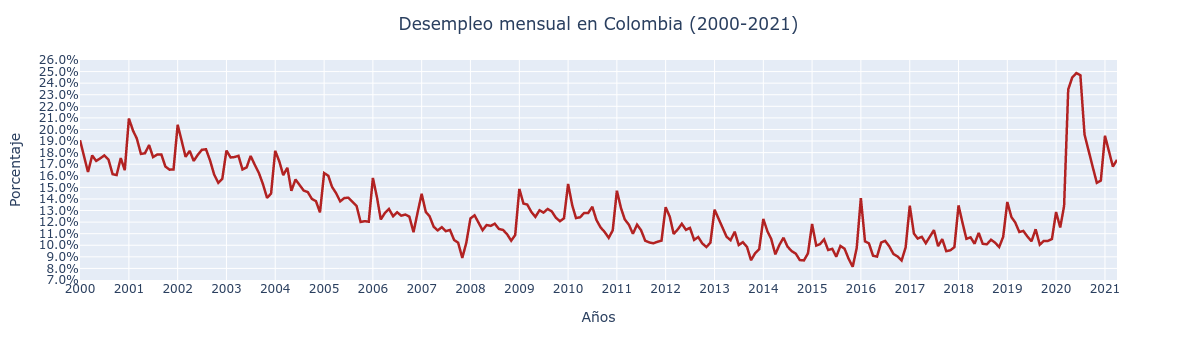

In [15]:
### Gráfica en Plotly
fig = px.line(bs, x=bs.index, y="desempleo",
             labels={"desempleo": "Porcentaje", 
                    "fecha": "Años"})
fig.update_layout(title_text='Desempleo mensual en Colombia (2000-2021)', title_x=0.5)
fig.update_xaxes(dtick="M12", tickformat="%Y")
fig.update_yaxes(dtick="1", range=[7,26], ticksuffix = ".0%")
fig.update_traces(line=dict(color="firebrick", width=2.5))

fig.show()

In [16]:
#### Inserto la columna de la tendencia
bs.insert(1, "tendencia", range(1, bs.shape[0]+1))

In [17]:
bs.head()

desempleo  tendencia
fecha                           
2000-01-01  19.075649          1
2000-02-01  17.741236          2
2000-03-01  16.321262          3
2000-04-01  17.757384          4
2000-05-01  17.284176          5

In [18]:
#### Nueva columna con el respectivo número del mes
bs["mes"] = pd.to_datetime(bs.index).month

In [19]:
#### Nuevo df con variables dummy
bs_dm = pd.get_dummies(bs.mes, drop_first=True)

In [20]:
#### Variables dummy
bs_dm.head()

2   3   4   5   6   7   8   9   10  11  12
fecha                                                 
2000-01-01   0   0   0   0   0   0   0   0   0   0   0
2000-02-01   1   0   0   0   0   0   0   0   0   0   0
2000-03-01   0   1   0   0   0   0   0   0   0   0   0
2000-04-01   0   0   1   0   0   0   0   0   0   0   0
2000-05-01   0   0   0   1   0   0   0   0   0   0   0

In [21]:
#### Pegando los dos df (bs y bs_dm)
bs_dm = pd.concat([bs, bs_dm], axis = 1)

In [22]:
#### Elimino la columna mes de bs_dm
bs_dm = bs_dm.drop("mes", axis = 1)

In [23]:
#### df de variables independientes
X = bs_dm.iloc[:, 1:bs_dm.shape[1]]

In [24]:
X.head()

tendencia  2  3  4  5  6  7  8  9  10  11  12
fecha                                                    
2000-01-01          1  0  0  0  0  0  0  0  0   0   0   0
2000-02-01          2  1  0  0  0  0  0  0  0   0   0   0
2000-03-01          3  0  1  0  0  0  0  0  0   0   0   0
2000-04-01          4  0  0  1  0  0  0  0  0   0   0   0
2000-05-01          5  0  0  0  1  0  0  0  0   0   0   0

In [25]:
#### df de la variable dependiente
Y = bs_dm.iloc[:, 0]

In [26]:
type(Y)

pandas.core.series.Series

In [27]:
Y

fecha
2000-01-01    19.075649
2000-02-01    17.741236
2000-03-01    16.321262
2000-04-01    17.757384
2000-05-01    17.284176
                ...    
2020-12-01    15.585572
2021-01-01    19.457349
2021-02-01    18.085593
2021-03-01    16.797761
2021-04-01    17.371046
Name: desempleo, Length: 256, dtype: float64

In [28]:
#### Agrego una columna de 1
X = sm.add_constant(X)

In [29]:
#### Implementando la regresión lineal múltiple
regre_1 = sm.OLS(Y, X).fit()

In [30]:
#### Tabla de salida de regre_1
salida = regre_1.summary()
print(salida)

                            OLS Regression Results                            
Dep. Variable:              desempleo   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     9.309
Date:                Wed, 03 Nov 2021   Prob (F-statistic):           9.30e-15
Time:                        13:03:12   Log-Likelihood:                -619.12
No. Observations:                 256   AIC:                             1264.
Df Residuals:                     243   BIC:                             1310.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.0140      0.666     27.058      0.0

In [31]:
#### Predicciones del modelo
predict = regre_1.predict(X)

In [32]:
### Predicciones de regre_1
predict

fecha
2000-01-01    17.993103
2000-02-01    16.652719
2000-03-01    15.972119
2000-04-01    16.258217
2000-05-01    15.693882
                ...    
2020-12-01     9.467272
2021-01-01    12.728487
2021-02-01    11.388104
2021-03-01    10.707503
2021-04-01    10.993601
Length: 256, dtype: float64

In [33]:
#### Pego la predicción de la regresión lineal a bs

bs = pd.concat([bs, predict.rename("desest")], axis = 1)

In [34]:
#### Tipo de las columnas
bs.dtypes

desempleo    float64
tendencia      int64
mes            int64
desest       float64
dtype: object

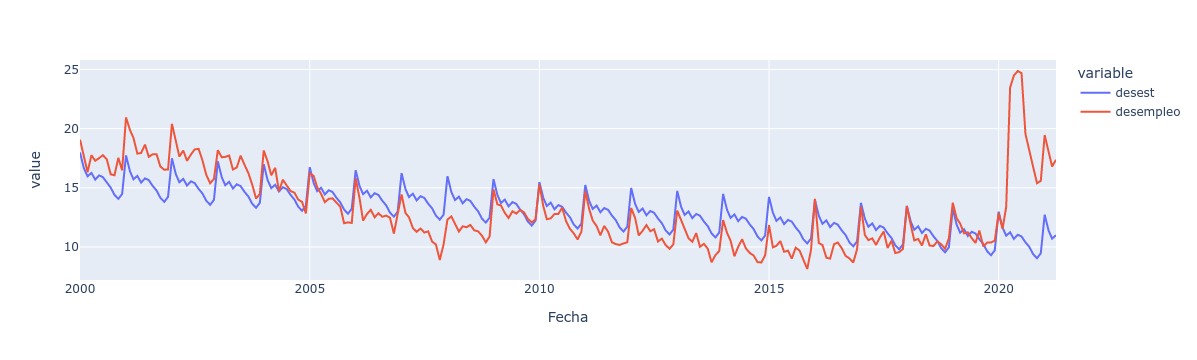

In [35]:
#### Gráfica desestacionalización con dummies
fig_1 = px.line(bs, x=bs.index, y=["desest", "desempleo"],
             labels={"fecha": "Fecha"})
fig_1.show()

In [ ]:
#### Exportar bs en formato Excel (.xlsx)